In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf


In [ ]:
# Define directories
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

In [3]:
image_size = (224, 224, 3)

In [4]:
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

In [6]:
# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [7]:
# Load MobileNet with pre-trained weights on ImageNet
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenet_with_gap = Model(inputs=base_mobilenet.input, outputs=x)

2024-04-29 15:11:42.732672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 861 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-04-29 15:11:42.736717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37781 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-04-29 15:11:42.739406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 6616 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-04-29 15:11:42.743103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37361 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

In [8]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [9]:
# tf.keras.backend.clear_session()

In [10]:
# Extract features using the model without the top layer in batches
batch_size = 8  # Adjust based on GPU memory
train_features = extract_features(mobilenet_with_gap, train_images, batch_size)
test_features = extract_features(mobilenet_with_gap, test_images, batch_size)

2024-04-29 15:11:44.721135: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-29 15:11:44.859321: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 0s 183ms/step


In [11]:
# Extract features using the model without the top layer
# train_features = mobilenet_with_gap.predict(train_images)
# test_features = mobilenet_with_gap.predict(test_images)

In [12]:
print(train_features.shape)
print(test_features.shape)

(7459, 1024)
(957, 1024)


In [13]:
# Define the parameter grid for Decision Tree
# dt_param_grid = {'criterion': ['entropy'], 'max_depth': [ 10]}
# # n_estimators:500, max_depth:10, criterion:'entropy'
# Define the expanded parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],  # Add more depth options
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Use GridSearchCV to find the best parameters for Decision Tree
dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(train_features, train_labels)

# Get the best parameters for Decision Tree
best_dt_params = dt_grid_search.best_params_

# Use the best parameters to train the final Decision Tree model
final_dt_classifier = DecisionTreeClassifier(**best_dt_params)
start_time_dt = time.time()
final_dt_classifier.fit(train_features, train_labels)
train_time_dt = time.time() - start_time_dt

# Predict labels for the test set using Decision Tree
dt_predictions = final_dt_classifier.predict(test_features)

# Evaluate accuracy for Decision Tree
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print("\nBest Decision Tree Parameters:", best_dt_params)
print("Decision Tree Accuracy:", dt_accuracy)



Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree Accuracy: 0.9425287356321839


In [14]:
# Additional evaluation metrics for Decision Tree
precision_dt = precision_score(test_labels, dt_predictions, average='weighted')
recall_dt = recall_score(test_labels, dt_predictions, average='weighted')
f1_dt = f1_score(test_labels, dt_predictions, average='weighted')

print("Train Time (sec) Decision Tree:", train_time_dt)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time_dt = dt_grid_search.cv_results_['mean_fit_time'][dt_grid_search.best_index_]
print("Train Time (sec) Grid Decision Tree:", grid_train_time_dt)

# Calculate Matthews Correlation Coefficient (MCC) for Decision Tree
mcc_dt = matthews_corrcoef(test_labels, dt_predictions)
print("Matthews Correlation Coefficient (MCC) Decision Tree:", mcc_dt)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = dt_grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)

Train Time (sec) Decision Tree: 11.280133247375488
Train Time (sec) Grid Decision Tree: 12.033696174621582
Matthews Correlation Coefficient (MCC) Decision Tree: 0.9332230249623674
Optimization Algorithm Accuracy: 0.9481165293637939


In [15]:
# Confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(test_labels, dt_predictions)
precision_dt = precision_score(test_labels, dt_predictions, average='weighted')

FP_dt = conf_matrix_dt.sum(axis=0) - np.diag(conf_matrix_dt)  
FN_dt = conf_matrix_dt.sum(axis=1) - np.diag(conf_matrix_dt)
TP_dt = np.diag(conf_matrix_dt)
TN_dt = conf_matrix_dt.sum()


In [16]:
# Display results for Decision Tree
print("\nResults for Decision Tree:")
print("Precision (Decision Tree):", precision_dt)
print("Recall (Decision Tree):", recall_dt)
print("F1 Score (Decision Tree):", f1_dt)
print("True Positive Rate (TPR) (Decision Tree):", np.mean(TP_dt / (TP_dt + FN_dt)))
print("True Negative Rate (TNR) (Decision Tree):", np.mean(TN_dt / (TN_dt + FP_dt)))
print("False Positive Rate (FPR) (Decision Tree):", np.mean(FP_dt / (FP_dt + TN_dt)))
print("False Negative Rate (FNR) (Decision Tree):", np.mean(FN_dt / (TP_dt + FN_dt)))

print("False Discovery Rate (FDR) (Decision Tree):", np.mean(FP_dt / (FP_dt + TP_dt)))
print("False Omission Rate (FOR) (Decision Tree):", np.mean(FN_dt / (FN_dt + TN_dt)))

print("Matthews Correlation Coefficient (MCC) (Decision Tree):", mcc_dt)


Results for Decision Tree:
Precision (Decision Tree): 0.9436873888271051
Recall (Decision Tree): 0.9425287356321839
F1 Score (Decision Tree): 0.9426130849465623
True Positive Rate (TPR) (Decision Tree): 0.8855479503273621
True Negative Rate (TNR) (Decision Tree): 0.9977170222804282
False Positive Rate (FPR) (Decision Tree): 0.002282977719571841
False Negative Rate (FNR) (Decision Tree): 0.11445204967263789
False Discovery Rate (FDR) (Decision Tree): 0.12415165389637817
False Omission Rate (FOR) (Decision Tree): 0.00228046239599623
Matthews Correlation Coefficient (MCC) (Decision Tree): 0.9332230249623674


In [17]:
conf_matrix_dt


array([[  3,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  19,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  16,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,  12,   1,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   3,   0,   0,   0,   0,   0,   1,   0,   0],
       [  1,   0,   0,   1,   0,   1,  10,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1],
      

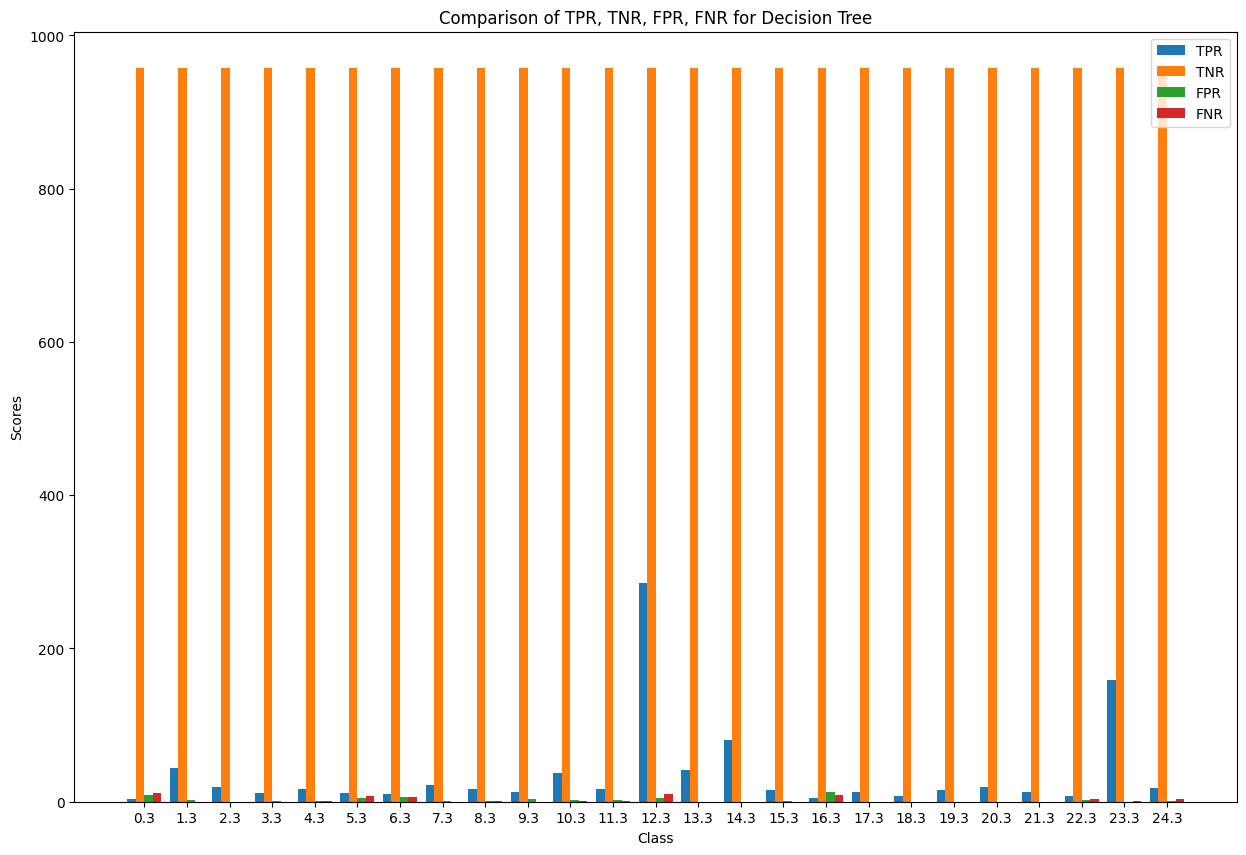

In [18]:
# Plot TPR, TNR, FPR, FNR for Decision Tree
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data



bar1 = ax.bar(index, TP_dt, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_dt, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_dt, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_dt, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for Decision Tree')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

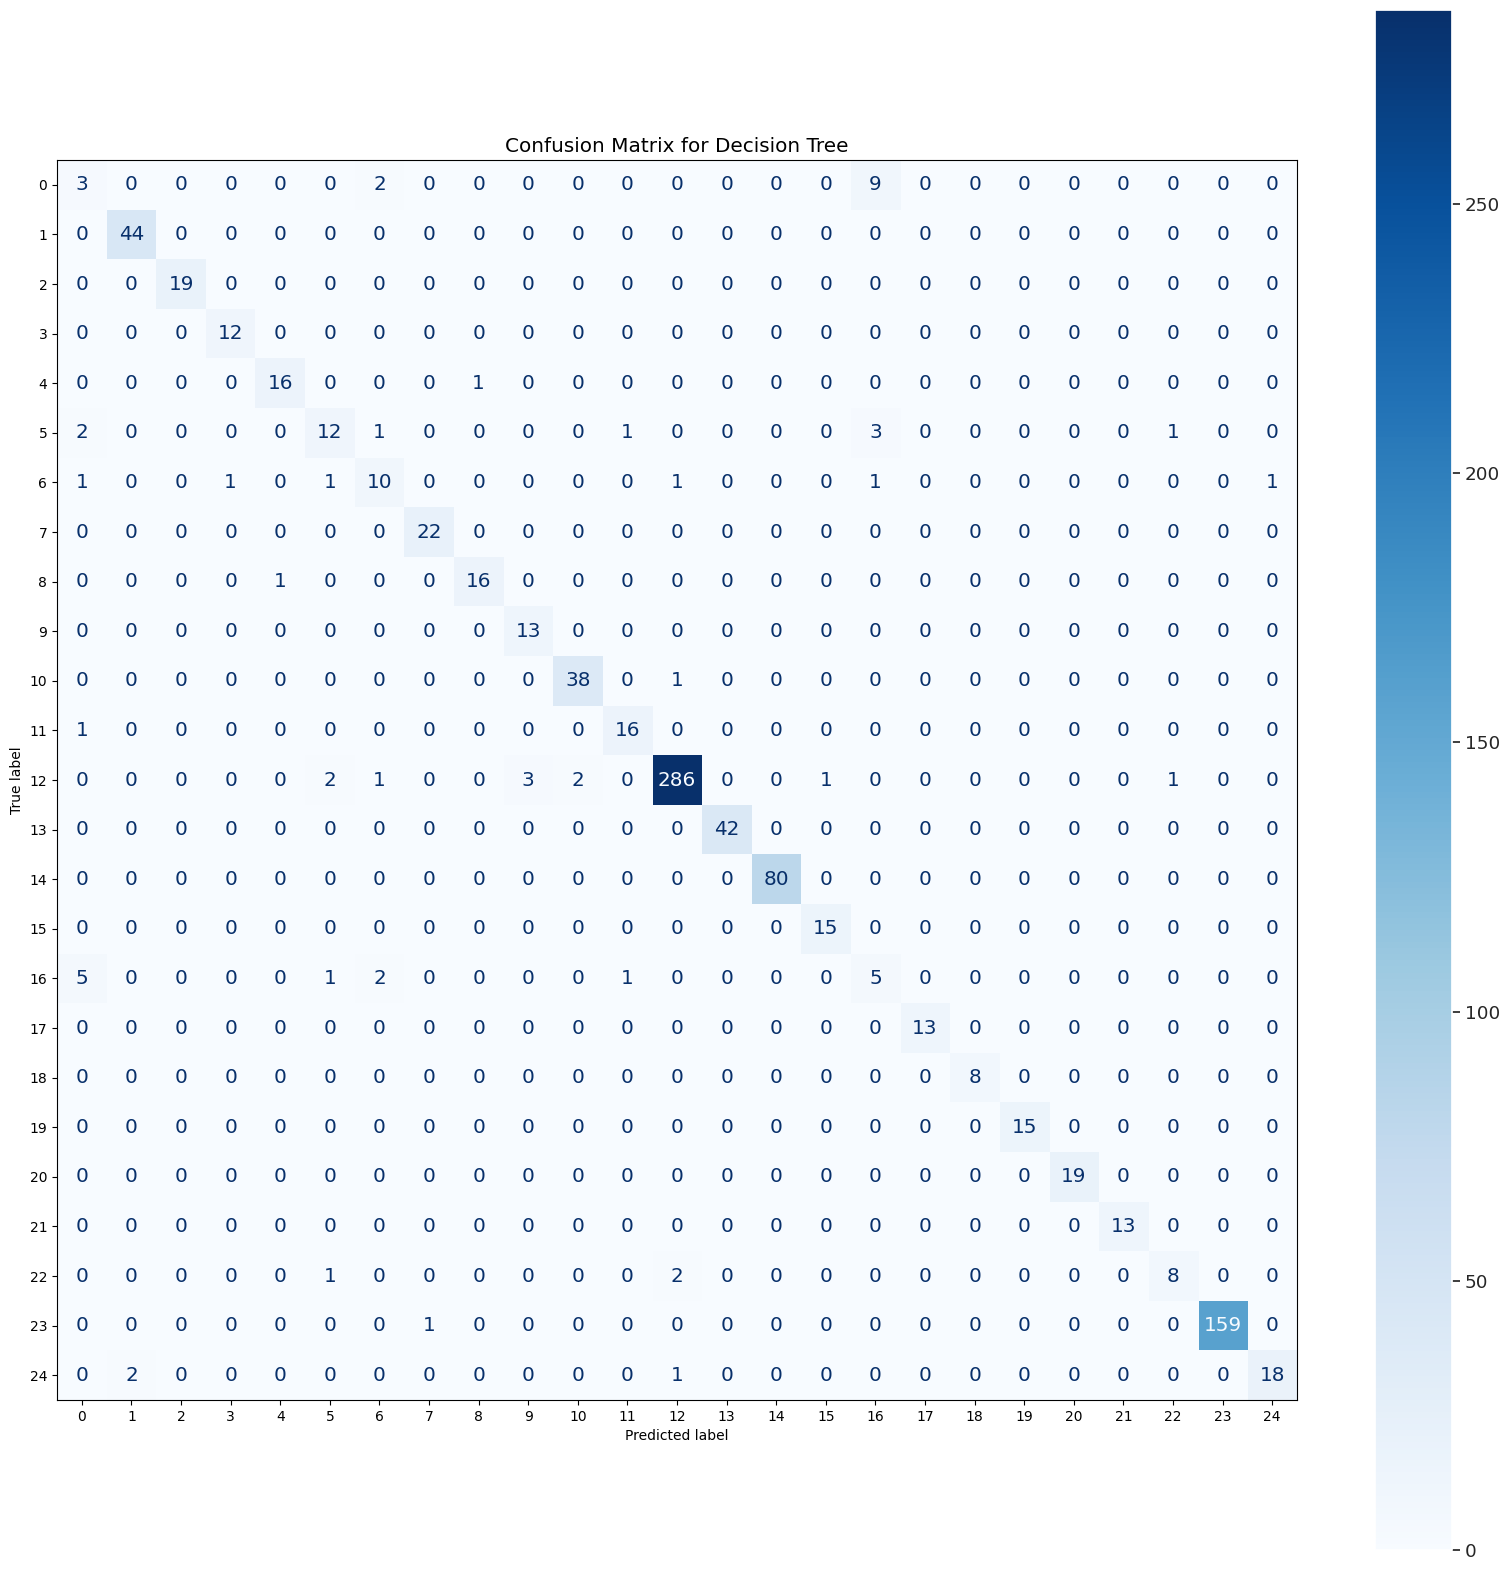

: 

In [19]:
# Plot Confusion Matrix for Decision Tree
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_dt, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Decision Tree')
plt.show()